In [1]:
%load_ext autoreload
%autoreload 2

import os
import dill
from tqdm import tqdm

import numpy as np
import pandas as pd

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_log_error

import matplotlib.pyplot as plt
import seaborn as sns

from src import pipeline_utils as pipe
from src import config as cfg
from src import training
from src import utils

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

np.random.seed(cfg.seed)

# Raw Data

In [2]:
df_train = pd.read_csv(os.path.join(cfg.data_path, 'train.tsv'), sep='\t')
df_test = pd.read_csv(os.path.join(cfg.data_path, 'test.tsv'), sep='\t')

y_train = df_train[cfg.target]
y_test = df_test[cfg.target]

print('train', df_train.shape[0])
print('test ', df_test.shape[0])
print('feats', df_train.shape[1])

train 5215
test  1738
feats 27


In [3]:
df_train.head().T

,0,1,2,3,4
backdrop_path,/7IBpOrw0ATwL1AOV97mtsceDpYs.jpg,/lYeE7k0OR3HXyoq7FeswyaxFJvL.jpg,/gVXLIfMR2hLmkn0nACctlMCJBfx.jpg,/rKjE17ncAGNzeImNWbdGTimzjtk.jpg,/zcJxJVhvxNHJJ2J7Q7NhgO9nPUV.jpg
belongs_to_collection,"{'id': 556, 'name': 'Spider-Man Collection', '...","{'id': 256296, 'name': 'Silent Night, Deadly N...",NaN,"{'id': 8917, 'name': 'Hellraiser Collection', ...","{'id': 108693, 'name': ""National Lampoon's Vac..."
budget,258000000,250000,0,1000000,15000000
genres,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...","[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...","[{'id': 99, 'name': 'Documentary'}]","[{'id': 27, 'name': 'Horror'}]","[{'id': 35, 'name': 'Comedy'}, {'id': 12, 'nam..."
homepage,https://www.sonypictures.com/movies/spiderman3,NaN,https://www.scottymovie.com/,NaN,NaN
id,559,50719,469062,9003,11153
imdb_id,tt0413300,tt0093974,tt2773246,tt0093177,tt0085995
original_language,en,en,en,en,en
original_title,Spider-Man 3,"Silent Night, Deadly Night Part 2",Scotty and the Secret History of Hollywood,Hellraiser,National Lampoon's Vacation
overview,The seemingly invincible Spider-Man goes up ag...,After being traumatized by his brother Billy's...,A deliciously scandalous portrait of unsung Ho...,An unfaithful wife encounters the zombie of he...,Clark Griswold is on a quest to take his famil...


In [4]:
describe = df_train.describe(include='all').T
describe['missing'] = len(df_train) - describe['count']
describe

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing
backdrop_path,4638,4638,/oi5EvMTKxhUngCveced3dwx1ctF.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,577
belongs_to_collection,1065,711,"{'id': 645, 'name': 'James Bond Collection', '...",18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4150
budget,5215,NaN,NaN,NaN,2.14797e+07,3.63151e+07,0,0,6.5e+06,2.6e+07,3.8e+08,0
genres,5215,1257,"[{'id': 18, 'name': 'Drama'}]",404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
homepage,1766,1754,https://www.happydeathday.com,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3449
id,5215,NaN,NaN,NaN,98768.7,143993,5,10136,24662,121704,679106,0
imdb_id,5200,5200,tt1706593,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
original_language,5215,43,en,4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
original_title,5215,5161,Tarzan,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
overview,5209,5206,No overview found.,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


## Dropped columns
by default we use all features except:
1. `belongs_to_collection` - not very informative, since each collection (in the train set) contains 18 (James Bond Collection) movies at most
2. `backdrop_path`  - not doing CV
3. `homepage` - mostly missing and not very useful
4. `id` - unique id, not useful
5. `imdb_id` - unique id, not useful
6. `original_title` - not doing NLP
7. `overview` - not doing NLP
8. `poster_path` - not doing CV
9. `status` - no variance
10. `tagline` - not doing NLP
11. `title` - not doing NLP

# `List[Dict[str, Any]]` columns
from each column only informative, non duplicative keys were kept, after filtering - each unique value was transformed to a count column
1. `genres`: `name`
2. `production_companies`: [`name`, `origin_country`]
3. `production_countries`: `iso_3166_1`
4. `spoken_languages`: `iso_639_1`
5. `Keywords`: `name`
6. `cast`: [`gender`,`name`]
7. `crew`: [`gender`,`job`,`name`]



# Numeric columns
no special transformation needed
1. `budget`
2. `popularity`
3. `runtime` - simple median imputation was performed
4. `video`
5. `vote_average`
6. `vote_count`

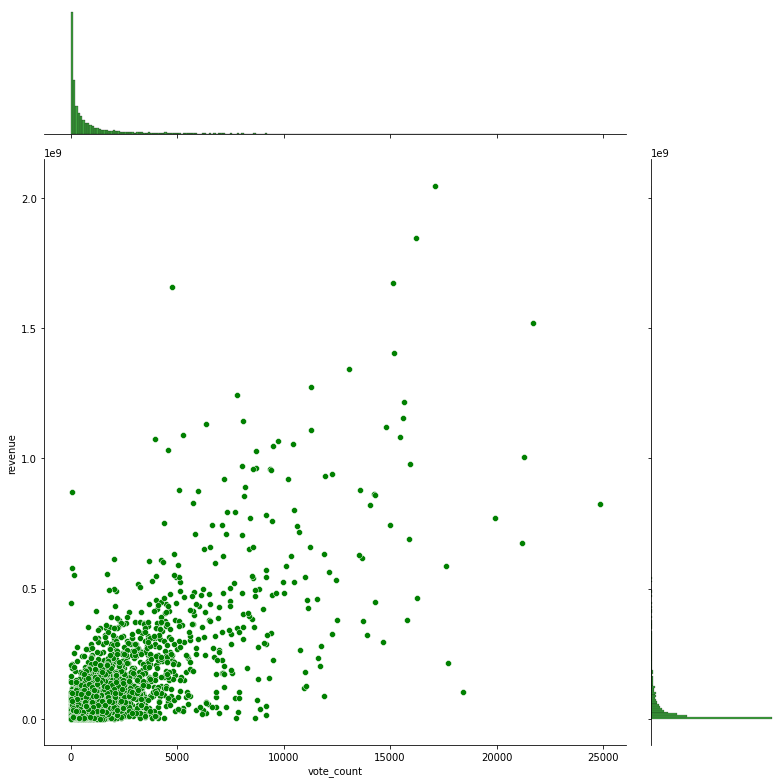

In [5]:
sns.jointplot(x='vote_count', y='revenue', data=df_train, height=11, ratio=4, color="g")
plt.show()

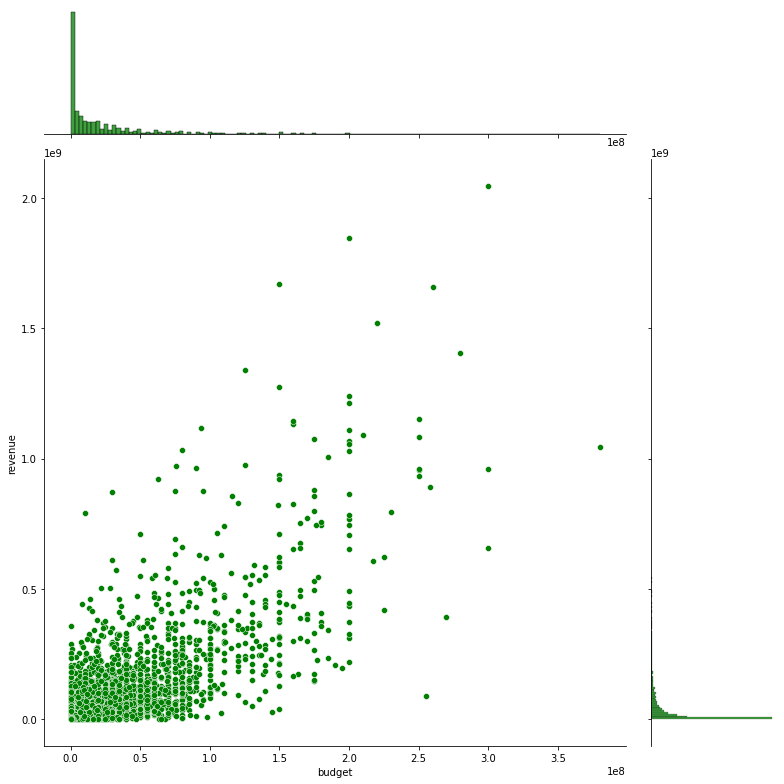

In [6]:
sns.jointplot(x='budget', y='revenue', data=df_train, height=11, ratio=4, color="g")
plt.show()

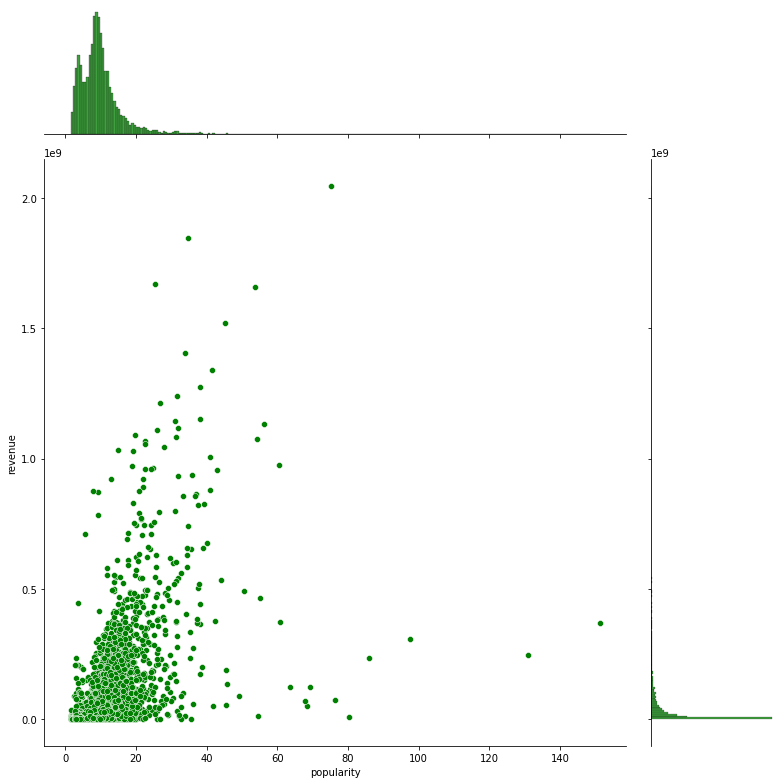

In [7]:
sns.jointplot(x='popularity', y='revenue', data=df_train, height=11, ratio=4, color="g")
plt.show()

# Preprocessing Pipeline

In [8]:
pipeline = Pipeline(steps=[
    # transform strings to List[Dict[str, Any]] 
    ('evaluator', FunctionTransformer(pipe.evaluator, kw_args={'feats': cfg.eval_cols})),
    
    # transform date string to date features: years since release date, month in polar representation (that captures month cyclical nature)
    ('Date_transformer', pipe.Date_transformer(cfg.date_cols)),
    
    # transform List[Dict[str, Any]] to count features of top values in selected dict keys
    ('Json_one_hot_encoder', pipe.Json_one_hot_encoder(cfg.json_list_cols, top=cfg.top, threshold=cfg.threshold)),
    
    # one hot encoding of categorical features
    ('One_hot_encoder', pipe.One_hot_encoder(cfg.one_hot_cols, top=cfg.top, threshold=cfg.threshold)),
    
    # remove unwanted columns
    ('column_dropper', FunctionTransformer(pipe.column_dropper, kw_args={'feats': cfg.drop_cols})),
    
    # remove special characters in column names that cause errors with some models
    ('special_char_remover', FunctionTransformer(pipe.special_char_remover)),
    
    # simple median imputation
    ('imputer', pipe.Imputer(cfg.median_impute, strategy='median')),
    
    # convert all values to float
    ('floaterizer', FunctionTransformer(lambda x: x.astype(float))),
    
    # select top features according to some feature importance huristic
#     ('column_selector', column_importance_selector(20, corr)),
])

In [9]:
# %%time
# pipeline.fit(df_train.copy())

In [10]:
# with open(os.path.join(cfg.final_models_path, cfg.final_pipeline_filename), 'wb') as f:
#     dill.dump(pipeline, f)

In [11]:
with open(os.path.join(cfg.final_models_path, cfg.final_pipeline_filename), 'rb') as f:
    pipeline = dill.load(f)

In [12]:
X_train = pipeline.transform(df_train.copy())
X_test = pipeline.transform(df_test.copy())

# assert there are no NaN values
assert X_train.isna().sum().sum() == 0

print('train', X_train.shape[0])
print('test ', X_test.shape[0])
print('feats', X_train.shape[1])

train 5215
test  1738
feats 200


# Processed Data

In [13]:
X_train.head().T.head(100)

,0,1,2,3,4
budget,2.580000e+08,250000.000000,0.000000,1.000000e+06,1.500000e+07
popularity,2.202400e+01,4.756000,4.746000,1.382800e+01,1.507000e+01
runtime,1.390000e+02,88.000000,98.000000,9.400000e+01,9.900000e+01
video,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
vote_average,6.200000e+00,4.300000,6.500000,6.900000e+00,7.100000e+00
vote_count,8.180000e+03,68.000000,15.000000,1.115000e+03,7.820000e+02
release_date_year,1.200000e+01,32.000000,1.000000,3.200000e+01,3.600000e+01
release_date_month_cos,-8.660254e-01,-0.500000,-0.866025,-1.836970e-16,-8.660254e-01
release_date_month_sin,5.000000e-01,0.866025,-0.500000,-1.000000e+00,-5.000000e-01
genres_name_Drama,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00


In [14]:
X_train.describe(include='all').T.tail(100)

,count,mean,std,min,25%,50%,75%,max
Keywords_name_sport,5215.0,0.022819,0.149340,0.0,0.0,0.0,0.0,1.0
Keywords_name_dystopia,5215.0,0.021477,0.144980,0.0,0.0,0.0,0.0,1.0
Keywords_name_siblingrelationship,5215.0,0.021477,0.144980,0.0,0.0,0.0,0.0,1.0
Keywords_name_teenager,5215.0,0.021477,0.144980,0.0,0.0,0.0,0.0,1.0
Keywords_name_aftercreditsstinger,5215.0,0.021285,0.144346,0.0,0.0,0.0,0.0,1.0
Keywords_name_losangelescalifornia,5215.0,0.020901,0.143067,0.0,0.0,0.0,0.0,1.0
Keywords_name_sex,5215.0,0.020518,0.141777,0.0,0.0,0.0,0.0,1.0
Keywords_name_remake,5215.0,0.019942,0.139816,0.0,0.0,0.0,0.0,1.0
Keywords_name_lossoflovedone,5215.0,0.019942,0.139816,0.0,0.0,0.0,0.0,1.0
Keywords_name_drugs,5215.0,0.019175,0.137155,0.0,0.0,0.0,0.0,1.0


In [15]:
utils.corr(X_train, y_train, only_y=True, drop_y_index=False)['y'].head(100)

y                                               1.000000
vote_count                                      0.769808
budget                                          0.753590
popularity                                      0.567924
crew_name_unique                                0.488459
crew_len                                        0.487750
crew_gender_2                                   0.475678
crew_gender_0                                   0.456842
crew_job_VisualEffectsSupervisor                0.408333
crew_job_ArtDirection                           0.407551
cast_gender_2                                   0.407514
cast_name_unique                                0.391561
cast_len                                        0.391190
crew_job_unique                                 0.388898
production_companies_origin_country_US          0.372756
crew_job_VisualEffectsEditor                    0.363200
crew_gender_1                                   0.362297
crew_job_ArtDepartmentCoordinat

# Models

In [16]:
model_name = 'lgb_1'
lgb_trainer = training.HyperoptTrainer(model_type='lgb',
                                   model_name=model_name,
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   models_path=cfg.models_path,
                                   seed=cfg.seed,
                                   importance=utils.corr(X_train, y_train)['y'],
                                   log_transform=True,
#                                    prints=True,

                                   # model hyperparams
                                   objective='regression',
                                   boosting_type='gbdt',
                                   verbosity=-1,
                                   n_jobs=-1,
                                   silent=True,
                                  )

lgb_trainer = training.HyperoptTrainer.load(lgb_trainer.get_path(best=False))

In [17]:
model_name = 'xgb_1'
xgb_trainer = training.HyperoptTrainer(model_type='xgb',
                                   model_name=model_name,
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   models_path=cfg.models_path,
                                   seed=cfg.seed,
                                   importance=utils.corr(X_train, y_train)['y'],
                                   log_transform=True,
#                                    prints=True,

                                   # model hyperparams
                                   objective='reg:squarederror',
                                   booster='gbtree',
                                   verbosity=0,
                                   n_jobs=-1,
                                  )
xgb_trainer = training.HyperoptTrainer.load(xgb_trainer.get_path(best=False))

In [18]:
model_name = 'rf_1'
rf_trainer = training.HyperoptTrainer(model_type='rf',
                                   model_name=model_name,
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   models_path=cfg.models_path,
                                   seed=cfg.seed,
                                   importance=utils.corr(X_train, y_train)['y'],
#                                    prints=True,

                                   # model hyperparams
                                   criterion='mse',
                                   verbose=0,
                                   n_jobs=-1,
                                  )
rf_trainer = training.HyperoptTrainer.load(rf_trainer.get_path(best=False))

In [19]:
lgb_trainer.fmin(cfg.lgb_space, max_evals=3500)

100%|█████████▉| 3498/3500 [00:00<?, ?trial/s, best loss=?]


In [20]:
xgb_trainer.fmin(cfg.xgb_space, max_evals=1180)

100%|█████████▉| 1175/1180 [00:00<?, ?trial/s, best loss=?]


In [21]:
rf_trainer.fmin(cfg.rf_space, max_evals=300)

 99%|█████████▊| 296/300 [00:00<?, ?trial/s, best loss=?]


# Best Results

In [22]:
display(lgb_trainer.log.sort_values('test_score', ascending=True).drop(columns=['hyperparam_dict', 'timestamp']).head(5))

,time,train_score,test_score,colsample_bytree,learning_rate,max_depth,min_child_samples,min_child_weight,min_split_gain,n_estimators,num_leaves,reg_alpha,reg_lambda,subsample,subsample_freq
3181,0.016088,1.461062,1.719441,0.503514,0.042166,5.0,3.0,0.351818,3.538144,1400.0,28.0,1.821918,0.850304,0.832948,80.0
3480,0.035542,1.322163,1.720214,0.551150,0.009503,6.0,3.0,0.380169,2.966870,1400.0,28.0,0.545499,0.176564,0.816514,320.0
3203,0.034258,1.243335,1.721309,0.493459,0.012056,6.0,3.0,0.455104,2.371043,1400.0,28.0,0.034016,0.389962,0.823512,200.0
3483,0.038149,1.255089,1.721671,0.517668,0.009121,6.0,2.0,0.443856,2.588167,1400.0,28.0,0.387565,0.005460,0.794629,280.0
3227,0.032063,1.255609,1.722914,0.495611,0.012841,6.0,3.0,0.420844,2.464345,1400.0,24.0,0.000230,0.000881,0.824142,200.0


In [23]:
display(xgb_trainer.log.sort_values('test_score', ascending=True).drop(columns=['hyperparam_dict', 'timestamp']).head(5))

,time,train_score,test_score,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample
1156,0.051114,1.573257,1.766554,0.822658,0.870302,0.859673,0.631940,0.628747,0.077460,3.0,2.494942,600.0,14.876657,6.004156,0.841143
1023,0.051051,1.597658,1.766757,0.992589,0.738699,0.940389,0.709644,0.977880,0.046659,4.0,5.600205,500.0,20.909881,7.183230,0.948513
789,0.028664,1.491821,1.768044,0.905026,0.711925,0.865464,0.606009,0.746594,0.066137,5.0,11.502893,260.0,9.788400,5.950829,0.869720
503,0.052526,1.437979,1.769635,0.837258,0.683263,0.896116,0.750884,0.951040,0.045138,5.0,22.781126,420.0,8.408399,1.039685,0.861090
1041,0.075593,1.304335,1.769712,0.992699,0.743373,0.913335,0.755855,1.003121,0.035696,6.0,7.206144,500.0,15.468359,6.493766,0.935099


In [24]:
display(rf_trainer.log.sort_values('test_score', ascending=True).drop(columns=['hyperparam_dict', 'timestamp']).head(5))

,time,train_score,test_score,bootstrap,max_depth,max_samples,min_weight_fraction_leaf,n_estimators
145,0.159324,2.284260,2.234496,False,50,None,0.003281,250.0
135,0.117956,2.075674,2.236130,False,45,None,0.001349,150.0
139,0.193692,2.274646,2.236274,False,45,None,0.003217,300.0
146,0.209754,2.221284,2.254236,False,50,None,0.002349,300.0
21,0.162351,2.304785,2.260433,False,20,None,0.003010,250.0


In [25]:
best_model = training.HyperoptTrainer.load(lgb_trainer.get_path(best=True))

In [26]:
preds = best_model.model.predict(X_test)

In [27]:
prediction_df = pd.DataFrame(columns=['id', 'revenue'])
prediction_df['id'] = X_test.index
prediction_df['revenue'] = preds
prediction_df['revenue'] = prediction_df['revenue'].apply(np.expm1)

In [28]:
np.sqrt(mean_squared_log_error(y_test, prediction_df['revenue']))

1.719440840040437

In [29]:
# best hyperparameters
best_model.model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5035139314914601,
 'importance_type': 'split',
 'learning_rate': 0.04216561306258736,
 'max_depth': 5,
 'min_child_samples': 3,
 'min_child_weight': 0.3518183706049972,
 'min_split_gain': 3.5381435628636435,
 'n_estimators': 1400,
 'n_jobs': -1,
 'num_leaves': 28,
 'objective': 'regression',
 'random_state': 42,
 'reg_alpha': 1.8219182740105122,
 'reg_lambda': 0.8503035235400165,
 'silent': True,
 'subsample': 0.8329481852883707,
 'subsample_for_bin': 200000,
 'subsample_freq': 80,
 'verbosity': -1}

In [30]:
# save best model
with open(os.path.join(cfg.final_models_path, cfg.final_model_filename), 'wb') as f:
    dill.dump(best_model.model, f)

# Test-run

In [31]:
# load best model
with open(os.path.join(cfg.final_models_path, cfg.final_model_filename), 'rb') as f:
    model = dill.load(f)

In [32]:
preds = model.predict(X_test)

prediction_df = pd.DataFrame(columns=['id', 'revenue'])
prediction_df['id'] = X_test.index
prediction_df['revenue'] = preds
prediction_df['revenue'] = prediction_df['revenue'].apply(np.expm1)

np.sqrt(mean_squared_log_error(y_test, prediction_df['revenue']))

1.719440840040437